<a href="https://colab.research.google.com/github/bhuvnk/skunkworks/blob/main/Phase1/1.%20Protonet/ProtoNet_miniImagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prototypical Netwoks: Mini Imagenet


`Credit:` [https://github.com/jakesnell/prototypical-networks](https://github.com/jakesnell/prototypical-networks)



# Important
Training Iterations on paper: 60,000 | Accuracy : 49.42

Implemented in this notebook : 60,000 | Accuracy : 48.91

## Mini Imagenet Data

Mini Imagenet pickle by some gentleman:
https://drive.google.com/file/d/1fJAK5WZTjerW7EWHHQAR9pRJVNg1T1Y7/view


In [1]:
# Download the MiniImagenet from Aauth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"1fJAK5WZTjerW7EWHHQAR9pRJVNg1T1Y7"})   
downloaded.GetContentFile('miniImageNet.zip') 

In [2]:
!mkdir miniImageNet
!unzip -qq miniImageNet.zip -d miniImageNet

##Import libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2
import random
import pickle as pkl
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [4]:
#Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


## Reading the MiniImagenet

* 64 character | Background Set | Training
* 16 Alphabets | Evaluation Set | Testing


In [5]:
#data path
data_path = '/content/miniImageNet'
train_path = data_path + '/miniImageNet_category_split_train_phase_train.pickle'
val_path = data_path + '/miniImageNet_category_split_val.pickle'
test_path = data_path + '/miniImageNet_category_split_test.pickle'

In [6]:
def load_data(data_file):
    dataset = read_file(data_file)
    data = dataset['data']
    labels = dataset['labels']
    label2ind = buildLabelIndex(labels)

    return {key: np.array(data[val]) for (key, val) in tqdm(label2ind.items())}

def read_file(data_file):
    try:
        with open(data_file, 'rb') as fo:
            data = pkl.load(fo)
        return data
    except:
        with open(data_file, 'rb') as f:
            u = pkl._Unpickler(f)
            u.encoding = 'latin1'
            data = u.load()
        return data

def buildLabelIndex(labels):
    label2inds = {}
    for idx, label in enumerate(labels):
        if label not in label2inds:
            label2inds[label] = []
        label2inds[label].append(idx)

    return label2inds

# Task Sampler

In [7]:
# Read the training data
train_data = load_data(train_path)

##Create samples

In [8]:
def extract_sample(n_way, n_support, n_query, data):
  """
    Returns a Task with support and query set combined
    task sample : (n_way, n_support+n_query, (image dim))
    plus these info: n_way, n_support, n_query
  """
  sample = []
  # K = np.random.choice(data.keys(), n_way, replace=False)
  K = random.sample(data.keys(), n_way)
  # print(K)

  # for (k, char) in enumerate(K):
  #   _imgs = data[char] # all the images for that class
  #   # Sample k_shot+n_query images from all images of that class
  #   sample_images = np.random.permutation(_imgs)[:(k_shot+n_query)]

  for cls in K:
    datax_cls = data[cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
  sample = np.array(sample)/255.
  sample = torch.from_numpy(sample).float()
  sample = sample.permute(0,1,4,2,3)
  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

As an example, let's pick a sample and display it

*   n_way = 8
*   n_support = 5
*   n_query = 5




In [9]:
sample_example = extract_sample(8, 5, 5, train_data)
sample_example['images'].shape

torch.Size([8, 10, 3, 84, 84])

* 8: classes
* [:, :5] = support images
* [:, 5:] = query images | 40 samples

8way, 5 shot learning

In [10]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

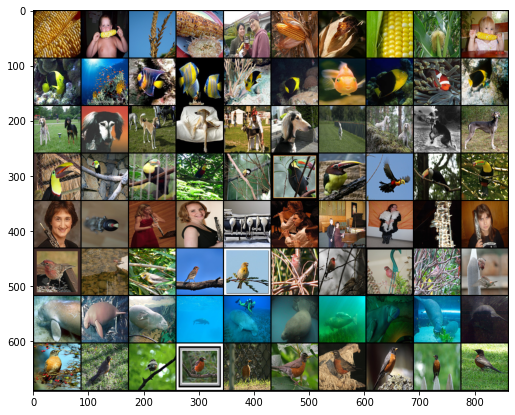

In [11]:
display_sample(sample_example['images'])

##Build model

Paper: [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

Embedding : 
* Input: (28x28x3) image 
* Returns : 64 lenght vector.

load_protonet_conv(Image2vector) function
* 4 modules
* each 64-filter 3 x 3 convolution -> BN -> ReLU -> 2 x 2 MP 

finally flattened to 64

In [12]:
## Encoder
def conv_block(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.MaxPool2d(2)
      )
  
class Image2vector(nn.Module):
    
    def __init__(self, **kwargs):
        super(Image2vector, self).__init__()
        
        self.conv1 = conv_block(3, 64) 
        self.conv2 = conv_block(64, 64) 
        self.conv3 = conv_block(64, 64) 
        self.conv4 = conv_block(64, 64) 
                
    def forward(self, x): # 3 *  28x28
        
        x = self.conv1(x) # 84 | 85 | 83 | 42 
        x = self.conv2(x) # 42 | 43 | 41 | 21 
        x = self.conv3(x) # 21 | 22 | 20 | 10
        x = self.conv4(x) # 10 | 11 | 9 | 5
        
        out = x.view(x.size(0), -1) # 64 embedding or maybe 64*5*5
        
        return out

In [13]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    encoder : CNN encoding the images in sample
    from sample data: 
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    self.encoder = encoder.cuda()

  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    sample_images = sample['images'].cuda()
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]
   
    #target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    target_inds = target_inds.cuda()
   
    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
   
    z = self.encoder.forward(x)
    # print(z.shape)
    z_dim = z.size(-1) #usually 64
    # print(z_dim)
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:]

    #compute distances
    dists = euclidean_dist(z_query, z_proto)
    
    #compute probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
    _, y_hat = log_p_y.max(2)

      
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
   
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }

In [14]:
def euclidean_dist(x, y):
  """
  Computes euclidean distance btw x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
  Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
  """
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

##Train

In [15]:
from tqdm import tqdm_notebook
from tqdm.notebook import tnrange

In [16]:
def train(model, optimizer, data, n_way, n_support, n_query, max_epoch, epoch_size):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  #divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    pbar = tqdm(total=epoch_size, desc='Epoch {}'.format(epoch+1))

    for episode in range(epoch_size):
      sample = extract_sample(n_way, n_support, n_query, data)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
      # Progress Bar Logging
      pbar.update(1)
      pbar.set_postfix({'Loss': output['loss'], 
                        'Accuracy': output['acc']})
        
    pbar.close()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    epoch += 1
    scheduler.step()

In [17]:
%%time
model = ProtoNet(Image2vector())
optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 5
n_support = 1
n_query = 15


max_epoch = 6
epoch_size = 10000 # episodes

train(model, optimizer, train_data, n_way, n_support, n_query, max_epoch, epoch_size)


Epoch 1 -- Loss: 2.1745 Acc: 0.3933



Epoch 2 -- Loss: 1.2065 Acc: 0.5104



Epoch 3 -- Loss: 1.0898 Acc: 0.5615



Epoch 4 -- Loss: 1.0260 Acc: 0.5884



Epoch 5 -- Loss: 0.9877 Acc: 0.6036



Epoch 6 -- Loss: 0.9663 Acc: 0.6129
CPU times: user 37min 47s, sys: 23min 18s, total: 1h 1min 6s
Wall time: 1h 55s


##Test

In [18]:
def test(model, data, n_way, n_support, n_query, test_episode):
  """
  Tests the protonet
  Args:
      model: trained model
      data: images and labels
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  running_loss = 0.0
  running_acc = 0.0
  with torch.no_grad():
    pbar = tqdm(total=test_episode, desc='Test Epoch')
    for episode in range(test_episode):

      sample = extract_sample(n_way, n_support, n_query, data)
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      
      pbar.update(1)
      pbar.set_postfix({'Loss': output['loss'], 
                        'Accuracy': output['acc']})
        
    pbar.close()
    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode

  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [19]:
# Read in evaluation/testing/validation data
test_data = load_data(val_path)

In [20]:
n_way = 5
n_support = 1
n_query = 15

test_episode = 10000

test(model, test_data, n_way, n_support, n_query, test_episode)


Test results -- Loss: 1.2480 Acc: 0.4891


##Test on specific example

Let's test the model on a specific example to visualize how well does it label the data

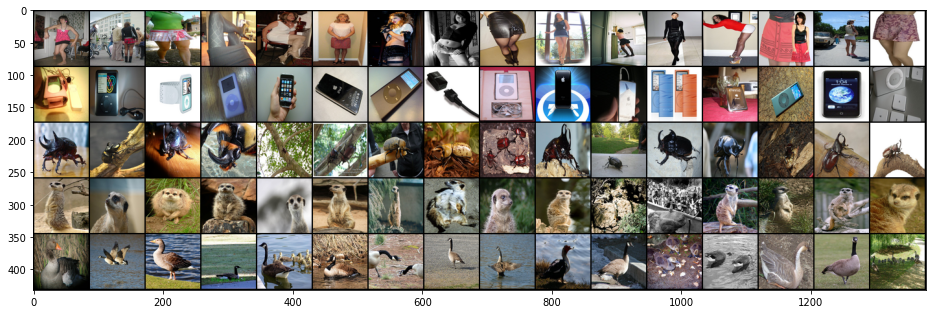

In [25]:
my_sample = extract_sample(n_way, n_support, n_query, test_data)
display_sample(my_sample['images'])

In [26]:
my_loss, my_output = model.set_forward_loss(my_sample)

In [27]:
my_output

{'acc': 0.4266666769981384,
 'loss': 1.3234446048736572,
 'y_hat': tensor([[2, 0, 0, 1, 1, 0, 1, 1, 0, 2, 2, 1, 1, 2, 0],
         [0, 0, 1, 1, 1, 1, 2, 0, 2, 1, 0, 0, 3, 0, 0],
         [2, 2, 2, 3, 4, 2, 4, 0, 2, 4, 2, 2, 4, 2, 3],
         [2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3],
         [2, 3, 3, 2, 2, 3, 3, 3, 2, 2, 4, 3, 3, 3, 4]], device='cuda:0')}